### Домашнее задание к уроку 5.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.special import expit

In [113]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

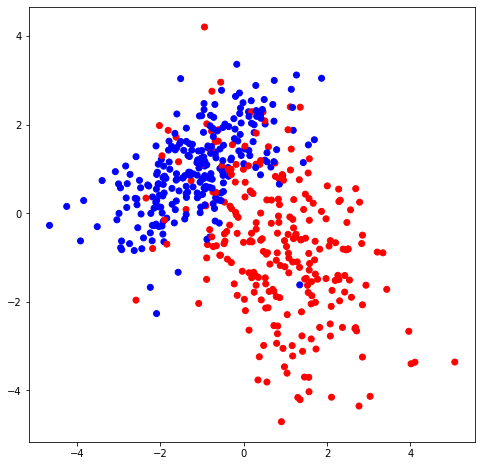

In [114]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [115]:
"""Реализуем генерацию  𝑁  бутстрап-выборок и подмножества признаков для нахождения разбиения в узле."""
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [116]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [117]:
"""Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями"""
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [118]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [119]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [120]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [121]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [122]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [123]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [124]:
"""Теперь добавим функцию формирования случайного леса."""
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [125]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [126]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [127]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [128]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

Accuracy: 0.9267


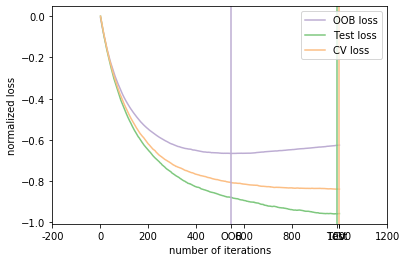

In [129]:
"""Количество деревьев - 1000, глубина - 1"""
# Классификатор точности с ООВ (out-of-bag)
params = {'n_estimators': 1000, 'max_depth': 1, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(train_data, train_labels)
acc = clf.score(test_data, test_labels)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1


def heldout_score(clf, test_data, test_labels):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, test_answers in enumerate(clf.staged_decision_function(test_data)):
        score[i] = clf.loss_(test_labels, test_answers)
    return score


def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(train_data, train_labels):
        cv_clf.fit(train_data[train], train_labels[train])
        val_scores += heldout_score(cv_clf, train_data[test], train_labels[test])
    val_scores /= n_splits
    return val_scores


# Оценка лучшего n_estimator (количество деревьев леса) с помощью cross-validation
cv_score = cv_estimate(3)

# Расчет лучшего n_estimator для тестовых данных
test_score = heldout_score(clf, test_data, test_labels)

# Отрицательная совокупная сумма улучшений OOB
cumsum = -np.cumsum(clf.oob_improvement_)

# минимальная потеря по OOB
oob_best_iter = x[np.argmin(cumsum)]

# минимальная потеря по тесту (Нормализовано так, чтобы первая потеря была 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# минимальная потеря по CV (Нормализовано так, чтобы первая потеря была 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# цвета для кривых
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# Построение кривые и вертикальные линии для лучших итераций
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# добавление трех вертикалных линий (xticks)
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()

Accuracy: 0.9733


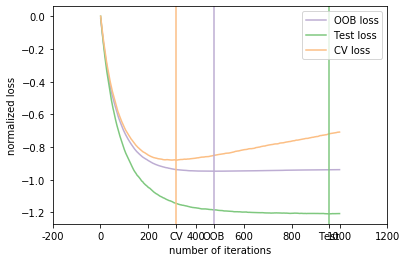

In [130]:
"""Количество деревьев - 1000, глубина - 5"""
# Классификатор точности с ООВ (out-of-bag)
params = {'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(train_data, train_labels)
acc = clf.score(test_data, test_labels)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1


def heldout_score(clf, test_data, test_labels):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, test_answers in enumerate(clf.staged_decision_function(test_data)):
        score[i] = clf.loss_(test_labels, test_answers)
    return score


def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(train_data, train_labels):
        cv_clf.fit(train_data[train], train_labels[train])
        val_scores += heldout_score(cv_clf, train_data[test], train_labels[test])
    val_scores /= n_splits
    return val_scores


# Оценка лучшего n_estimator (количество деревьев леса) с помощью cross-validation
cv_score = cv_estimate(3)

# Расчет лучшего n_estimator для тестовых данных
test_score = heldout_score(clf, test_data, test_labels)

# Отрицательная совокупная сумма улучшений OOB
cumsum = -np.cumsum(clf.oob_improvement_)

# минимальная потеря по OOB
oob_best_iter = x[np.argmin(cumsum)]

# минимальная потеря по тесту (Нормализовано так, чтобы первая потеря была 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# минимальная потеря по CV (Нормализовано так, чтобы первая потеря была 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# цвета для кривых
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# Построение кривые и вертикальные линии для лучших итераций
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# добавление трех вертикалных линий (xticks)
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()

Accuracy: 0.9800


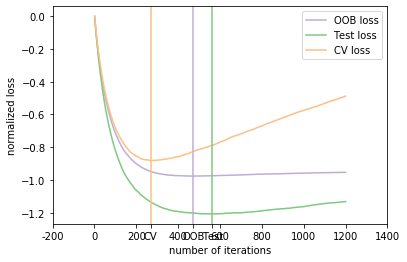

In [131]:
"""Количество деревьев - 1200, глубина - 9"""
# Классификатор точности с ООВ (out-of-bag)
params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(train_data, train_labels)
acc = clf.score(test_data, test_labels)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1


def heldout_score(clf, test_data, test_labels):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, test_answers in enumerate(clf.staged_decision_function(test_data)):
        score[i] = clf.loss_(test_labels, test_answers)
    return score


def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(train_data, train_labels):
        cv_clf.fit(train_data[train], train_labels[train])
        val_scores += heldout_score(cv_clf, train_data[test], train_labels[test])
    val_scores /= n_splits
    return val_scores


# Оценка лучшего n_estimator (количество деревьев леса) с помощью cross-validation
cv_score = cv_estimate(3)

# Расчет лучшего n_estimator для тестовых данных
test_score = heldout_score(clf, test_data, test_labels)

# Отрицательная совокупная сумма улучшений OOB
cumsum = -np.cumsum(clf.oob_improvement_)

# минимальная потеря по OOB
oob_best_iter = x[np.argmin(cumsum)]

# минимальная потеря по тесту (Нормализовано так, чтобы первая потеря была 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# минимальная потеря по CV (Нормализовано так, чтобы первая потеря была 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# цвета для кривых
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# Построение кривые и вертикальные линии для лучших итераций
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# добавление трех вертикалных линий (xticks)
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()